In [2]:
cd("..")
include("full_scene.jl")

    .-(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:285
is ambiguous with: 
    .-(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:40.
To fix, define 
    .-(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    .==(AbstractArray{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:330
is ambiguous with: 
    .==(Images.AbstractImageDirect{Bool, N<:Any}, AbstractArray{Bool, N<:Any}) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:181.
To fix, define 
    .==(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}})
before the new definition.
    .==(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDa

plot_convergence (generic function with 1 method)

# Load Factor Graph Model

In [3]:
include("full_scene.jl")

model_file = get_most_resent_file("output")
saved_model = JLD.load(model_file)
println("save time: ", saved_model["time"])

factors = create_core_factors()
set_weights!(factors, saved_model["weights"])
println("DONE")

save time: 2016-06-08T11:00:08
DONE

# Load Dataset

In [4]:
include("full_scene.jl")
tic()
dsetexp = JLD.load("output/dsetexport.jld", "dsetexp")
toc()

println("nscenes: ", length(dsetexp.scenes))
println("nvehstates: ", length(dsetexp.states))
println("ave veh / scene: ", length(dsetexp.states)/length(dsetexp.scenes))

tic()
dset = reconstruct_dataset(dsetexp, create_core_factors())
toc()

elapsed time: 1.195918624 seconds
nscenes: 3977
nvehstates: 87201
ave veh / scene: 21.926326376665827
elapsed time: 

0.826712906 seconds


0.826712906

In [15]:
include("full_scene.jl")
canvas_width = 600
canvas_height = 600
output_dir = "/home/tim/Documents/papers/2016_itsc_scenegen_wheeler/figures/"

real
scene_indeces = [1, 1001, 2201]
for (i,scene_index) in enumerate(scene_indeces)
    scene_index = scene_indeces[i]
    scene, structure = get_scene_and_structure(dset, scene_index)
    filename = joinpath(output_dir, @sprintf("scene%d_real.pdf", i))
    fout = open(filename, "w")
    s = CairoPDFSurface(filename, canvas_width, canvas_height)
    rendermodel = RenderModel()
    rendermodel.color_transform = grayscale_transform
    render_scene!(scene, camerazoom=2.5,
        canvas_width=canvas_width, canvas_height=canvas_height, s=s, rendermodel=rendermodel
    )
    finish(s)
end

# rand
proposal_distribution = MvNormal([2.0, 0.5, 1.0, 0.01]) # s, t, v, theta standard deviations
n_steps = 1000
extractor = Scene()

for (i,scene_index) in enumerate(scene_indeces)
    scene, structure = get_scene_and_structure(dset, scene_index)
    copy!(extractor, scene)
    metropolis_hastings!(extractor, structure, factors, proposal_distribution, n_steps)
    
    filename = joinpath(output_dir, @sprintf("scene%d_rand.pdf", i))
    fout = open(filename, "w")
    s = CairoPDFSurface(filename, canvas_width, canvas_height)
    rendermodel = RenderModel()
    rendermodel.color_transform = grayscale_transform
    render_scene!(extractor, camerazoom=2.5,
        canvas_width=canvas_width, canvas_height=canvas_height, s=s, rendermodel=rendermodel
    )
    finish(s)
end

Interact.Slider{Int64}(Signal{Int64}(1989, nactions=0),"scene_index",1989,1:3977,true)

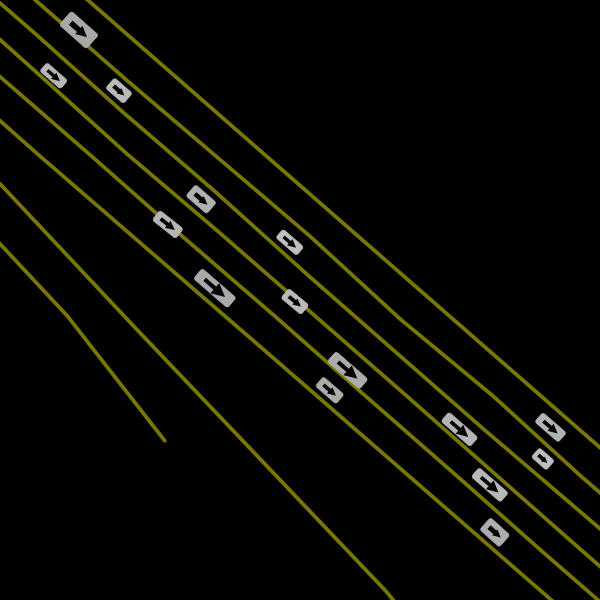

In [20]:
@manipulate for scene_index in 1 : length(dset)
    scene, structure = get_scene_and_structure(dset, scene_index)
    render_scene!(scene, camerazoom=2.5) # structure
end

# Sample Metropolis-Hastings Dataset

In [11]:
include("full_scene.jl")

scene_index = 1000
proposal_distribution = MvNormal([2.0, 0.5, 1.0, 0.01]) # s, t, v, theta standard deviations
scene, structure = get_scene_and_structure(dset, scene_index)
scene = deepcopy(scene)
n_steps = 5

@manipulate for step in 1 : 100
    metropolis_hastings!(scene, structure, factors, proposal_distribution, n_steps)
    render_scene!(scene, structure, camerazoom=1.5)
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"step",50,1:100,true)

LoadError: LoadError: UndefVarError: paint_with_alpha not defined
while loading In[11], in expression starting on line 9

In [26]:
include("full_scene.jl")
transition = MvNormal([2.0, 0.5, 1.0, 0.01]) # s, t, v, theta standard deviations
dataset_size = 1000
nsteps_burnin = 1000
FG = FactorGraphSceneGenerator(factors, transition, nsteps_burnin)

tic()
dset_FG = generate_dset(FG, dset, dataset_size)
toc()
JLD.save(joinpath(SAVE_DIR, "dset_FG.jld"), "dset", dset_FG, "time", string(now()))
"done"

Interact.Slider{Int64}(Signal{Int64}(500, nactions=0),"scene_index",500,1:1000,true)

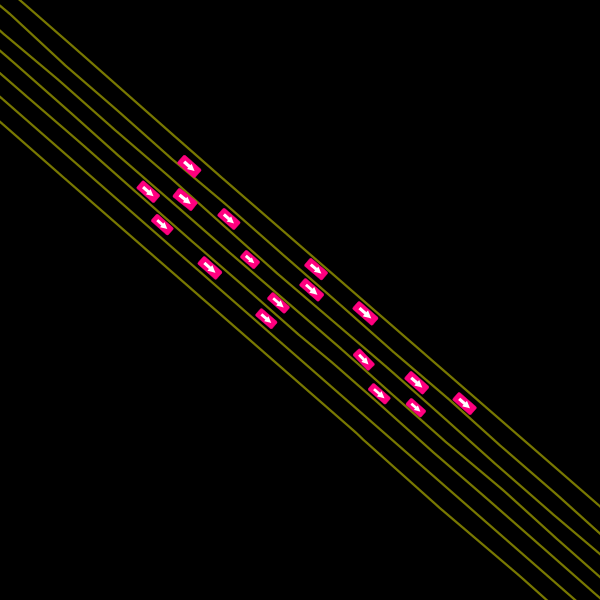

In [9]:
@manipulate for scene_index in 1 : length(scenes_FG)
    scene = scenes_FG[scene_index]
    render_scene!(scene, camerazoom=1.5)
end

In [30]:
include("full_scene.jl")
roadscenes = get_roadscene_dset(dset)
nbins = Dict{Symbol, Int}(:speed=>5, :d_cl=>5, :yaw=>5, :d_front=>5, :v_front=>5, :d_rear=>5, :v_rear=>5)

tic()
BN = train_jointbnchainscenegenerator(roadscenes, nbins)
toc()

tic()
dset_BN = generate_dset(BN, dset, dataset_size)
toc()
JLD.save(joinpath(SAVE_DIR, "dset_BN.jld"), "dset", dset_BN, "time", string(now()))
nothing

elapsed time: 5.349481342 seconds


elapsed time: 2.293537834 seconds
